In [1]:
import pyvista 
pyvista.global_theme.trame.server_proxy_enabled = True
pyvista.start_xvfb()

In [2]:
import jax

jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools

In [3]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle, ellipse
import itertools
from matplotlib.gridspec import GridSpec

In [4]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from fft_operators import laplacian_operator, gradient_operator
from custom_solvers import conjugate_gradient

from fd_decorators import (
    compute_perturb_deformation_gradient,
    finite_difference,
    finite_difference_grid,
)

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])

from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

## constructing an architected material 

- inclusion = 1
- solid = 0


We construct the RVE with an volume fraction of 0.7 %

In [5]:
structure = np.load("./figs/blurred_lattice.npy")
structure = np.where(structure < 0.6, 0, 1)
H, L = structure.shape
size = np.minimum(H, L)
if size % 2 == 0:
    size = size - 1
structure = structure[:size, :size]

In [6]:
length = 1.0
H, L = structure.shape
dx = length / H
dy = length / L

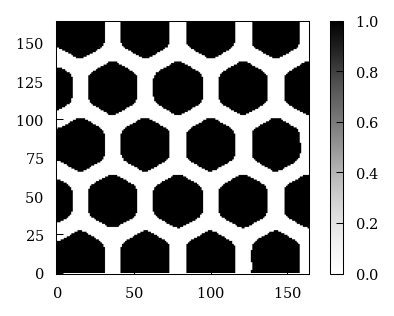

In [7]:
plt.figure()
cb = plt.imshow(structure, origin="lower", cmap="Greys")
plt.colorbar(cb)
plt.show()

In [8]:
ndim = len(structure.shape)
N = structure.shape[0]
shape = [
    N,
] * ndim

In [9]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I2 = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)


I4s = (I4 + I4rt) / 2.0
II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

One must varu the `phase_constrast` variable in the following cells and the resulting `homogneized stiffness tensor` is stored in the variable `output_data`.

In [10]:
output_data = []

## material parameters

In [11]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["inclusion", "solid"])
def param(X, inclusion, solid):
    return inclusion * jnp.ones_like(X) * (X) + solid * jnp.ones_like(X) * (1 - X)

In [12]:
# material parameters
phase_contrast = 1 / 10000.0

# lames constant
lambda_modulus = {"solid": 1.0, "inclusion": phase_contrast}
shear_modulus = {"solid": 1.0, "inclusion": phase_contrast}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = (
    lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3
)

In [13]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

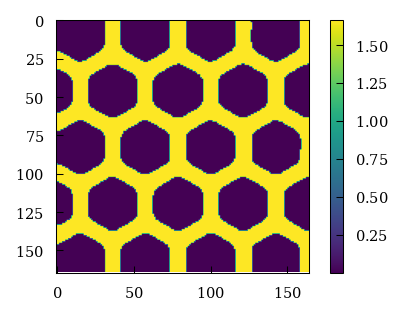

In [14]:
plt.imshow(K0)
plt.colorbar()

## linear elastic constitutive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$
$$\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$


In [15]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5 * (eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym))
    )
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

## fft helpers and operators

In [16]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

Projection tensor

In [17]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="rotated", length=length)

In [18]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@jax.jit
def G_K_deps(depsm, additionals):
    depsm = depsm.reshape(ndim, ndim, N, N)
    return G(sigma(depsm))

## newton-raphson method

In [19]:
@jax.jit
def solve_elasticity(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        dF, b, F, Fn = state

        dF, iiter = conjugate_gradient(
            atol=1e-8, A=G_K_deps, b=b, additional=None
        )  # solve linear system using CG

        dF = dF.reshape(ndim, ndim, N, N)
        F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
        P = sigma(F)  # new residual stress
        b = -G_K_deps(F, None)  # compute residual

        return (dF, b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

## testing elastic subproblem for a loaded state

In [20]:
sig = jnp.zeros([ndim, ndim, N, N])
eps = jnp.zeros([ndim, ndim, N, N])


deps = jnp.zeros([ndim, ndim, N, N])
deps = deps.at[0, 0].set(1e-1)
#deps = deps.at[1, 1].set(1e-1)

# initial residual: distribute "DE" over grid using "K4"
b = -G_K_deps(deps, None)
eps = jax.lax.add(eps, deps)
En = jnp.linalg.norm(eps)

In [21]:
state = (deps, b, eps, En)
state = jax.device_put(state)

In [22]:
final_state, xs = jax.lax.scan(solve_elasticity, init=state, xs=jnp.arange(0, 20))

residual=1.0
residual=1.0424054044432964
residual=0.005862671049446296
residual=0.00019237160831170636
residual=1.038223024325539e-05
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0


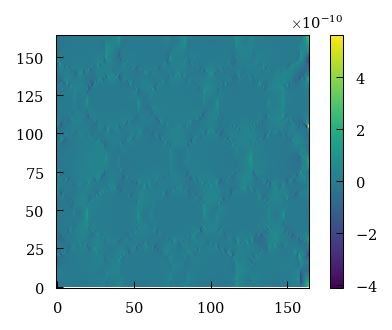

In [23]:
plt.figure()
plt.imshow(final_state[1].reshape([ndim, ndim, N, N]).at[1, 1].get(), origin="lower")
plt.colorbar()

In [24]:
sig = sigma(final_state[2])

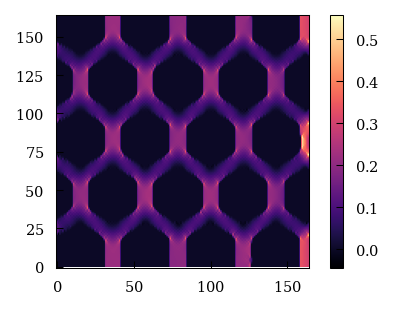

In [25]:
plt.figure()
plt.imshow(sig.at[0, 0].get(), origin="lower", cmap="magma")
plt.colorbar()

In [26]:
@finite_difference(increment=1e-8, has_aux=True)
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps = jnp.zeros([ndim, ndim, N, N])
    # set macroscopic loading
    DE = jnp.zeros([ndim, ndim, N, N])
    DE = DE.at[0, 0].set(macro_strain.at[0, 0].get())
    DE = DE.at[1, 1].set(macro_strain.at[1, 1].get())
    DE = DE.at[0, 1].set(macro_strain.at[0, 1].get() / 2.0)
    DE = DE.at[1, 0].set(macro_strain.at[1, 0].get() / 2.0)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(DE, None)
    eps = jax.lax.add(eps, DE)
    En = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    #initial_state = jax.device_put(state)
    initial_state = state
    
    final_state, xs = jax.lax.scan(
        solve_elasticity, init=initial_state, xs=jnp.arange(0, 20)
    )

    DE, b, eps, En = final_state
    sig = sigma(eps)

    # get the macro stress
    macro_sigma = jnp.array(
        [
            jnp.sum(sig.at[0, 0].get() * dx * dy),
            jnp.sum(sig.at[1, 1].get() * dx * dy),
            0.5
            * (
                jnp.sum(sig.at[1, 0].get() * dx * dy)
                + jnp.sum(sig.at[0, 1].get() * dx * dy)
            ),
        ]
    )
    macro_sigma = macro_sigma / length**2

    return jnp.array(
        [
            [macro_sigma.at[0].get(), macro_sigma.at[2].get()],
            [macro_sigma.at[2].get(), macro_sigma.at[1].get()],
        ]
    )  , (macro_sigma, sig, eps)

In [50]:
deps = jnp.array([[-1e-2, 0], [0, -1e-2]])

In [51]:
import timeit

In [52]:
start = timeit.default_timer()
tangent, state = local_constitutive_update(deps)
print(timeit.default_timer()-start)

residual=1.0
residual=0.8549361670892547
residual=0.004861808386775572
residual=0.0002224395537273999
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=4.019455430331141e-07
residual=1.0
residual=0.8549362719496089
residual=0.004861805490128662
residual=0.0002224498055095649
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0024260434315026e-07
residual=4.0

In [53]:
tangent

array([[[[ 5.10124159e-01, -6.72735999e-04],
         [-5.92971158e-04,  2.40179064e-01]],

        [[-1.22888489e-03,  2.97114092e-02],
         [ 2.97092290e-02, -5.94021111e-04]]],


       [[[-1.22888489e-03,  2.97114092e-02],
         [ 2.97092290e-02, -5.94021111e-04]],

        [[ 2.39183010e-01, -2.26967316e-04],
         [-3.08215172e-04,  4.22668636e-01]]]])

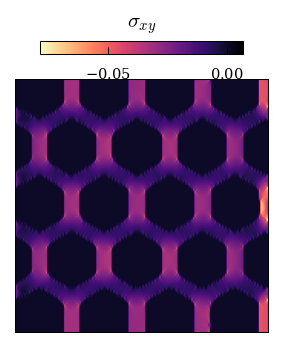

In [54]:
fig = plt.figure()
ax = plt.axes()
plot_imshow(
    fig=fig,
    ax=ax,
    quantity=state[1].at[0, 0].get(),
    title=r"$\sigma_{xy}$",
    cmap="magma_r",
)

In [55]:
values = np.asarray(state[1].at[0, 0].get())

x = np.linspace(0, 1, structure.shape[0])
y = np.linspace(0, 1, structure.shape[1])
xx, yy = np.meshgrid(x, y)

In [56]:
points = np.c_[xx.reshape(-1), yy.reshape(-1), np.zeros(N*N).reshape(-1)]

In [57]:
cloud = pyvista.PolyData(points)

In [58]:
surf = cloud.delaunay_2d()

In [59]:
eps_xx = np.asarray(state[2].at[0, 0].get()).reshape(-1)
eps_xy = np.asarray(state[2].at[0, 1].get()).reshape(-1)
eps_yy = np.asarray(state[2].at[1, 1].get()).reshape(-1)

In [60]:
surf.point_data['sigma_xx'] = values.reshape(-1)
surf.point_data['eps_xx'] = eps_xx
surf.point_data['phase'] = 1-structure.reshape(-1)

In [61]:
u_3D = np.zeros((N*N, 3))
u_3D[:, 0] = surf.points[:, 0]*eps_xx*(1-structure).reshape(-1) + surf.points[:, 1]*eps_xy*(1-structure).reshape(-1)
u_3D[:, 1] = surf.points[:, 0]*eps_xy*(1-structure).reshape(-1) + surf.points[:, 1]*eps_yy*(1-structure).reshape(-1)


In [62]:
surf.point_data["Displacement"] = u_3D
surf.set_active_vectors("Displacement")

In [63]:
threshold = surf.threshold(value=0.02,continuous=False, scalars='phase')
plotter = pyvista.Plotter()
plotter.window_size = (900, 400)
plotter.add_mesh(threshold)
edges = threshold.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/34865/index.html?ui=P_0x15365b77a5d0_8&reconnect=auto" class="p…

In [73]:
surf_2 = threshold.extract_geometry()
threshold_2 = surf_2.smooth(
    boundary_smoothing=True,
    feature_smoothing=False,
    n_iter=100,
    relaxation_factor=0.05,
    edge_angle=120,
)

In [74]:
plotter = pyvista.Plotter()
plotter.window_size = (900, 400)
plotter.add_mesh(threshold_2, scalars='eps_xx', cmap='magma_r')

edges = threshold_2.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/34865/index.html?ui=P_0x15365b015c50_15&reconnect=auto" class="…

In [80]:
warped = threshold_2.warp_by_vector("Displacement", factor=1)
plotter = pyvista.Plotter()
plotter.window_size = (800, 400)
plotter.add_mesh(warped, scalars='Displacement', cmap='Spectral')

edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.1)
plotter.view_xy()

plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/34865/index.html?ui=P_0x153659933fd0_20&reconnect=auto" class="…

In [76]:
surf_3 = warped.extract_geometry()
threshold_3 = surf_3.smooth(
    boundary_smoothing=True,
    feature_smoothing=False,
    n_iter=100,
    relaxation_factor=0.05,
    edge_angle=120,
)

In [77]:
warped_3 = threshold_3.warp_by_vector("Displacement", factor=1)
plotter = pyvista.Plotter()
plotter.window_size = (800, 400)
plotter.add_mesh(warped_3, scalars='Displacement', cmap='Spectral')
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/34865/index.html?ui=P_0x15365a63f490_17&reconnect=auto" class="…

In [640]:
np.min(state[1][0, 0, :, :])

Array(-0.00137796, dtype=float64)

In [600]:
np.max(mesh_ux)

0.03248689868101557